# GAN

In [23]:
!pip install livelossplot

In [24]:
import numpy as np
import datetime, time
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses


In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
import zipfile
import os

# Path to your ZIP file
zip_file_path = '/content/gdrive/MyDrive/Data/Data.zip'
# Directory where you want to unzip the contents
unzip_dir = '/content/gdrive/MyDrive/Data/unzipped/'

# Ensure the unzip directory exists
os.makedirs(unzip_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"Files unzipped to {unzip_dir}")


Files unzipped to /content/gdrive/MyDrive/Data/unzipped/


In [ ]:
# load the training data and reshape
train = np.load('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_train.npy')

print(f"Before reshaping: {np.shape(train)}")

train_1D = np.reshape(
    train, (np.shape(train)[0], np.shape(train)[1] * np.shape(train)[2])
)
print(f"After reshaping: {train_1D.shape}")

train = np.array(train)
train_1D = np.array(train_1D)

Before reshaping: (12500, 256, 256)
After reshaping: (12500, 65536)


In [ ]:
# load the test data and reshape
test = np.load('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_test.npy')

print(f"Before reshaping: {np.shape(test)}")

test_1D = np.reshape(
    test, (np.shape(test)[0], np.shape(test)[1] * np.shape(test)[2])
)
print(f"After reshaping: {test_1D.shape}")

test = np.array(test)
test_1D = np.array(test_1D)

Before reshaping: (5000, 256, 256)
After reshaping: (5000, 65536)


In [27]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=256*256):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim=256*256):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# build model
G = Generator().to(device)
D = Discriminator().to(device)

# define loss
criterion = nn.BCELoss()
z_dim = 100

# optimiser
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x.view(-1, 256*256), torch.ones(batch_size, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached


In [ ]:
# DataLoader

# Convert your training data to PyTorch tensors
train_data = torch.tensor(train_1D, dtype=torch.float32)
test_data = torch.tensor(test_1D, dtype=torch.float32)

# Create a TensorDataset from your training data

# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)

# Specify batch size
batch_size = 100

# Create a DataLoader for your training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def G_train(x):
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(batch_size, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached


In [ ]:
n_epoch = 100
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses = [], []
    logs = {}

    for batch_idx, (real_images,) in enumerate(train_loader):
        real_images = real_images.view(-1, 256*256).to(device)

        D_loss = D_train(real_images)
        G_loss = G_train(real_images.size(0))

        D_losses.append(D_loss)
        G_losses.append(G_loss)

    logs['D_Loss'] = torch.tensor(D_losses).mean().item()
    logs['G_Loss'] = torch.tensor(G_losses).mean().item()

    liveloss.update(logs)
    liveloss.draw()

    # save after training
    if(np.mod(epoch, 100) == 0):
      torch.save(G.state_dict(), "./GAN/Generator_{:03d}.pth".format(epoch))

In [ ]:
G.load_state_dict(torch.load("./GAN/Generator_{:03d}.pth".format(epoch)))

with torch.no_grad():
    test_z = torch.randn(batch_size, z_dim).to(device)
    generated = G(test_z)

    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 256, 256).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

# Testing DCGAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=256):
        super().__init__()
        self.init_size = g_output_dim // 16
        self.fc1 = nn.Linear(g_input_dim, 128 * self.init_size ** 2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # print("Generator input shape:", x.shape)
        x = self.fc1(x)
        # print("After fc1 shape:", x.shape)
        x = x.view(x.shape[0], 128, self.init_size, self.init_size)
        # print("After view shape:", x.shape)
        x = self.conv_blocks(x)
        # print("After conv_blocks shape:", x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self, d_input_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(16, 32, 3, 2, 1),
            # nn.ZeroPad2d((0, 1, 0, 1)),  # the fucking mismatch is from here
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        # Calculate the expected input size for the linear layer
        ds_size = d_input_dim // 8
        self.linear_input_size = 128 * ds_size ** 2
        self.adv_layer = nn.Sequential(nn.Linear(self.linear_input_size, 1), nn.Sigmoid())

    def forward(self, x):
        # print("Discriminator input shape:", x.shape)
        x = self.model(x)
        # print("After model shape:", x.shape)
        x = x.view(x.size(0), -1)  # Flatten the output
        # print("After flatten shape:", x.shape)
        x = self.adv_layer(x)
        return x

In [ ]:
# build model
G = Generator().to(device)
D = Discriminator().to(device)

# define loss
criterion = nn.BCELoss()
z_dim = 100

# optimiser
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
class NumpyDataset(Dataset):

    def __init__(self, data_path, transform=None):
        self.data = np.load(data_path).astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = torch.from_numpy(image)
        if self.transform:
          image = self.transform(image)
        return image

In [ ]:
# DataLoader

# Convert your training data to PyTorch tensors
# train_data = torch.tensor(train, dtype=torch.float32)
# test_data = torch.tensor(test, dtype=torch.float32)

# Create a TensorDataset from your training data

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5), std=(0.5))])

train_data = NumpyDataset('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_train.npy', transform=transform)
test_data = NumpyDataset('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_test.npy', transform=transform)

# Specify batch size
#with depreceated functionality in torch, this needs to be an even divisible of
#the total input size
batch_size = 100

# Create a DataLoader for your training dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
def D_train(x):
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x.view(-1, 1, 256, 256), torch.ones(batch_size, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached


In [ ]:
def G_train(x):
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(batch_size, 1).to(device)
    # G_loss = criterion(D_output, y)
    G_loss = criterion(D_output, torch.ones_like(D_output))

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached


In [ ]:
# Iterate over the train_loader to inspect the shape of the data batches
for batch_idx, data in enumerate(train_loader):
    print(f"Batch {batch_idx+1} - Data shape: {data.shape}")
    if batch_idx == 4:  # Just to show the first 5 batches
        break

Batch 1 - Data shape: torch.Size([100, 1, 256, 256])
Batch 2 - Data shape: torch.Size([100, 1, 256, 256])
Batch 3 - Data shape: torch.Size([100, 1, 256, 256])
Batch 4 - Data shape: torch.Size([100, 1, 256, 256])
Batch 5 - Data shape: torch.Size([100, 1, 256, 256])


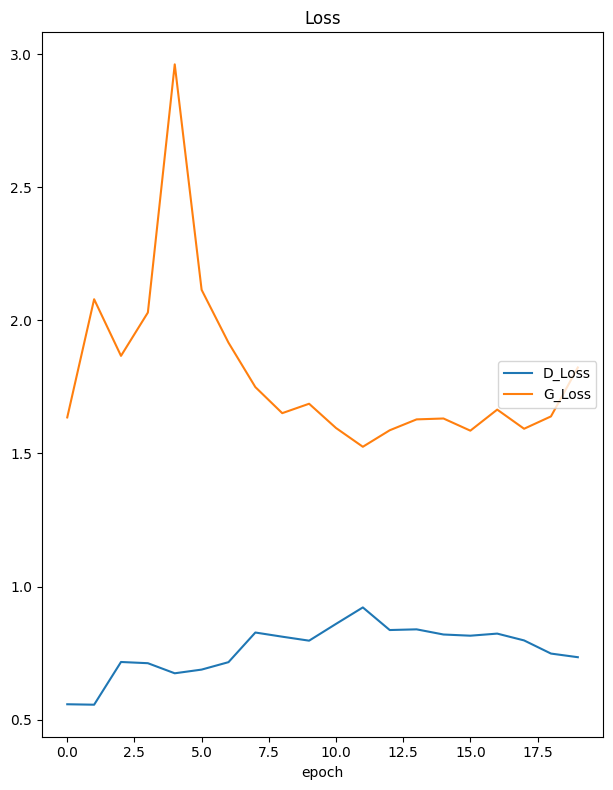

Loss
	D_Loss           	 (min:    0.557, max:    0.922, cur:    0.735)
	G_Loss           	 (min:    1.525, max:    2.961, cur:    1.823)


RuntimeError: Parent directory ./exp does not exist.

In [ ]:
n_epoch = 20
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses = [], []
    logs = {}

    for batch_idx, real_images in enumerate(train_loader):
        real_images = real_images.view(-1, 256, 256).to(device)

        D_loss = D_train(real_images)
        # G_loss = G_train(batch_size)
        G_loss = G_train(real_images.size(0))

        D_losses.append(D_loss)
        G_losses.append(G_loss)

    logs['D_Loss'] = torch.tensor(D_losses).mean().item()
    logs['G_Loss'] = torch.tensor(G_losses).mean().item()

    liveloss.update(logs)
    liveloss.draw()


In [ ]:
    # save every 20th epochs
    if(np.mod(epoch, 20) == 0):
      torch.save(G.state_dict(), "/content/gdrive/MyDrive/Model/Generator_{:03d}.pth".format(epoch))

In [ ]:
#load in the saved model

generator_model = G.load_state_dict(torch.load("/content/gdrive/MyDrive/Model/Generator_020.pth".format(epoch)))

In [ ]:
def calculate_mse(test_loader, generator_model, device):
    generator_model.eval()  # Set the model to evaluation mode
    mse_loss = nn.MSELoss()  # Use PyTorch's built-in MSELoss
    total_mse = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculation
        for images in test_loader:
            images = images.to(device)
            z = torch.randn(images.size(0), z_dim, device = device)
            generated_images = generator_model(z)

            mse = mse_loss(generated_images, images).item()
            total_mse += mse
            num_batches += 1

    average_mse = total_mse / num_batches
    return average_mse


In [ ]:

# Assuming you have a test_loader ready and the generator model 'G' and device set
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

In [39]:
import matplotlib.pyplot as plt
import torch

def visualize_generated_images(generator_model, device, z_dim, num_images_to_generate=5):
    generator_model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        # Generate latent vectors
        z = torch.randn(num_images_to_generate, z_dim, device=device)
        generated_images = generator_model(z)

    # Display generated images
    fig, axes = plt.subplots(1, num_images_to_generate, figsize=(15, 5))
    for idx in range(num_images_to_generate):
        axes[idx].imshow(generated_images[idx].cpu().permute(1, 2, 0), cmap = "hot")  # Assumes images are in (C, H, W) format
        axes[idx].set_title("Generated Image")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


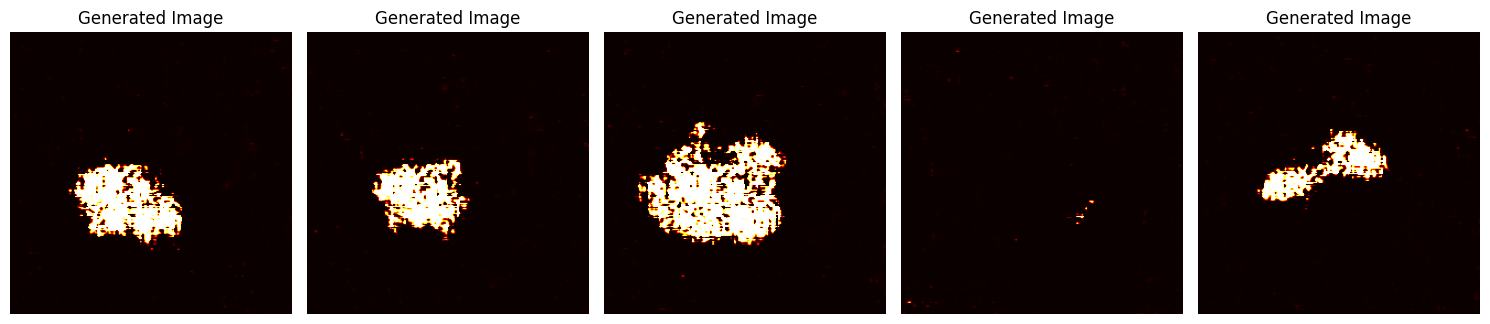

In [ ]:
# Assuming 'G' is your generator model, 'device' is your computation device (CPU or GPU), and 'z_dim' is the dimension of the latent space
z_dim = 100  # Replace with the correct dimension of the latent space

# Visualize generated images
visualize_generated_images(G, device, z_dim, num_images_to_generate=5)


In [47]:
import random
def visualize_random_train_images(train_loader, num_images_to_show=5):
    # Retrieve a batch of images from the training set
    data_iter = iter(train_loader)
    batch = next(data_iter)

    # Check the structure of the batch
    if isinstance(batch, (list, tuple)) and len(batch) > 1:
        images = batch[0]  # Assuming images are the first element
    else:
        images = batch

    # Select a random subset of images
    indices = random.sample(range(images.size(0)), num_images_to_show)
    selected_images = images[indices]

    # Display the images
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
    for idx in range(num_images_to_show):
        axes[idx].imshow(selected_images[idx].permute(1, 2, 0), cmap = 'hot')  # Assumes images are in (C, H, W) format
        axes[idx].set_title("Train Image")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()




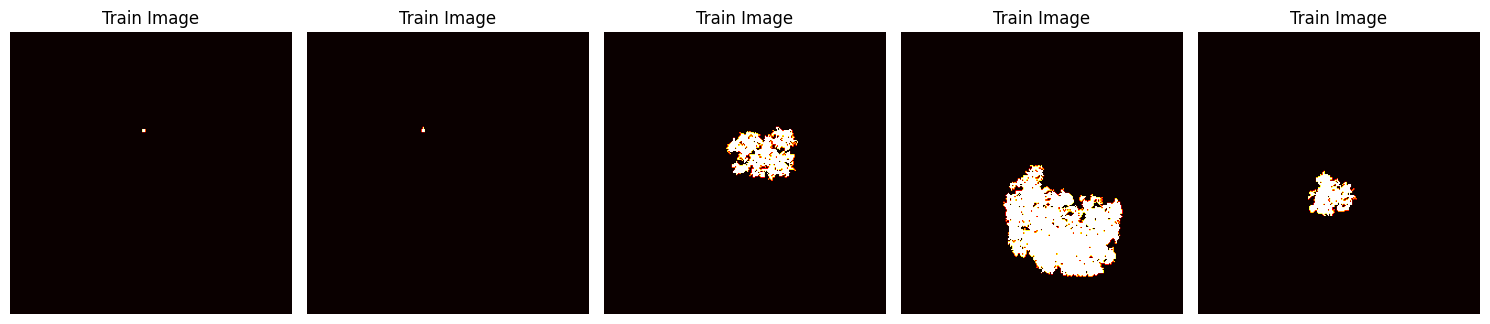

In [48]:
visualize_random_train_images(train_loader, num_images_to_show=5)

Another attempt at a GAN architecture

In [28]:
import torchvision.transforms.functional as F

class CenterZoom(object):
    def __init__(self, zoom_factor):
        self.zoom_factor = zoom_factor

    def __call__(self, img):
        # Calculate crop size
        width, height = img.size
        new_width = int(width / self.zoom_factor)
        new_height = int(height / self.zoom_factor)
        left = (width - new_width) / 2
        top = (height - new_height) / 2
        right = (width + new_width) / 2
        bottom = (height + new_height) / 2
        # Apply central crop
        img = F.crop(img, top, left, new_height, new_width)
        return img

# Define the central zoom factor
zoom_factor = 2  # Adjust this value as needed

# Update the transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),
    CenterZoom(zoom_factor),  # Apply central zoom
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])


In [ ]:
# Applying central zoom


train_data = NumpyDataset('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_train.npy', transform=transform)
test_data = NumpyDataset('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_test.npy', transform=transform)

# Specify batch size
#with depreceated functionality in torch, this needs to be an even divisible of
#the total input size
batch_size = 100

# Create a DataLoader for your training dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [29]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=256):
        super().__init__()
        self.init_size = g_output_dim // 16
        self.fc1 = nn.Linear(g_input_dim, 128 * self.init_size ** 2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(x.shape[0], 128, self.init_size, self.init_size)
        x = self.conv_blocks(x)
        return x


In [30]:
import torch.nn.utils.spectral_norm as spectral_norm

class Discriminator(nn.Module):
    def __init__(self, d_input_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 16, 3, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(16, 32, 3, 2, 1)),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(32, 64, 3, 2, 1)),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(64, 128, 3, 1, 1)),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        ds_size = d_input_dim // 8
        self.linear_input_size = 128 * ds_size ** 2
        self.adv_layer = nn.Sequential(nn.Linear(self.linear_input_size, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.adv_layer(x)
        return x


In [31]:
# build model
G = Generator().to(device)
D = Discriminator().to(device)

# define loss
criterion = nn.BCELoss()
z_dim = 100

# optimiser
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [32]:
def D_train(x):
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x.view(-1, 1, 256, 256), torch.ones(batch_size, 1)  # we are assigning the label 'real data' to the samples (don't care anymore about what number they are)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached


In [33]:
def G_train(x):
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(batch_size, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(batch_size, 1).to(device)
    # G_loss = criterion(D_output, y)
    G_loss = criterion(D_output, torch.ones_like(D_output))

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()  ### deprecated version of loss.detach(), basically gets access to the tensor without the computational graph attached


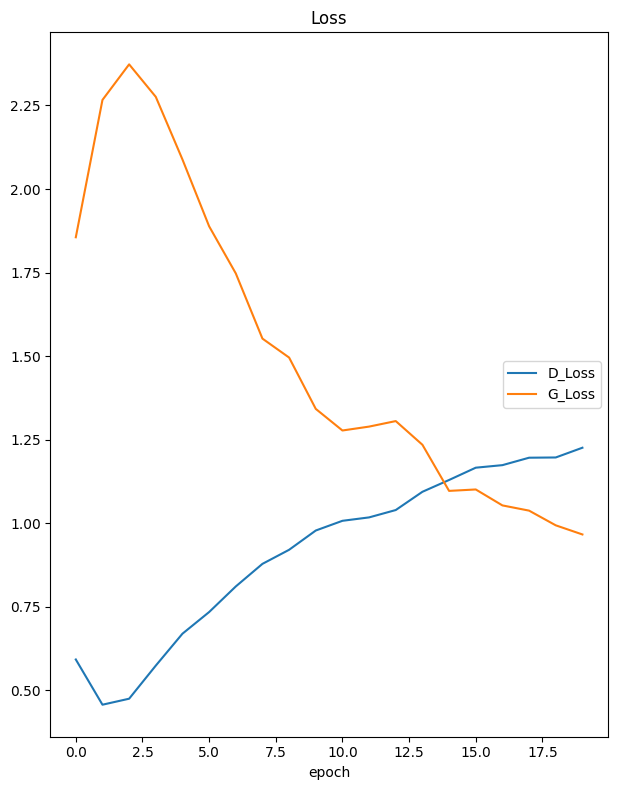

Loss
	D_Loss           	 (min:    0.457, max:    1.226, cur:    1.226)
	G_Loss           	 (min:    0.967, max:    2.373, cur:    0.967)


In [ ]:
n_epoch = 20
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses = [], []
    logs = {}

    for batch_idx, real_images in enumerate(train_loader):
        real_images = real_images.view(-1, 256, 256).to(device)

        D_loss = D_train(real_images)
        # G_loss = G_train(batch_size)
        G_loss = G_train(real_images.size(0))

        D_losses.append(D_loss)
        G_losses.append(G_loss)

    logs['D_Loss'] = torch.tensor(D_losses).mean().item()
    logs['G_Loss'] = torch.tensor(G_losses).mean().item()

    liveloss.update(logs)
    liveloss.draw()

    # save every 20th epochs
    if(np.mod(epoch, 20) == 0):
      torch.save(G.state_dict(), "/content/gdrive/MyDrive/Model/Generator2_{:03d}.pth".format(epoch))


In [ ]:
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.6509176075458527


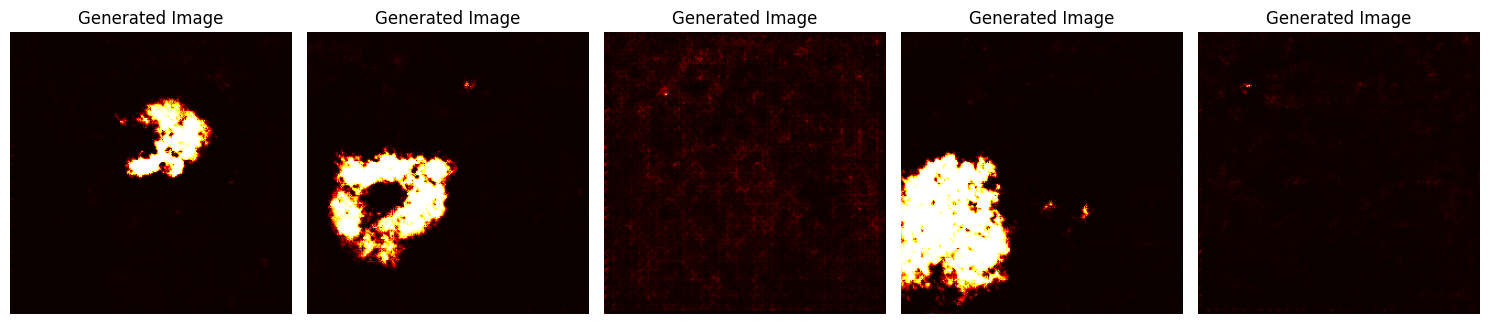

In [ ]:
# Assuming 'G' is your generator model, 'device' is your computation device (CPU or GPU), and 'z_dim' is the dimension of the latent space
z_dim = 100  # Replace with the correct dimension of the latent space

# Visualize generated images
visualize_generated_images(G, device, z_dim, num_images_to_generate=5)


Same architecture without central zoom

In [34]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [35]:
train_data = NumpyDataset('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_train.npy', transform=transform)
test_data = NumpyDataset('/content/gdrive/MyDrive/Data/unzipped/Data/Ferguson_fire_test.npy', transform=transform)

# Specify batch size
#with depreceated functionality in torch, this needs to be an even divisible of
#the total input size
batch_size = 100

# Create a DataLoader for your training dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [60]:
n_epoch = 100
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses = [], []
    logs = {}

    for batch_idx, real_images in enumerate(train_loader):
        real_images = real_images.view(-1, 256, 256).to(device)

        D_loss = D_train(real_images)
        # G_loss = G_train(batch_size)
        G_loss = G_train(real_images.size(0))

        D_losses.append(D_loss)
        G_losses.append(G_loss)

    logs['D_Loss'] = torch.tensor(D_losses).mean().item()
    logs['G_Loss'] = torch.tensor(G_losses).mean().item()

    liveloss.update(logs)
    liveloss.draw()

    # save every 10th epochs
    if(np.mod(epoch, 10) == 0):
      torch.save(G.state_dict(), "/content/gdrive/MyDrive/Model/GAN_best_{:03d}.pth".format(epoch))


KeyboardInterrupt: 

In [36]:
G.load_state_dict(torch.load('/content/gdrive/MyDrive/Model/Generator_no_zoom_060.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [37]:
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.22593389570713043


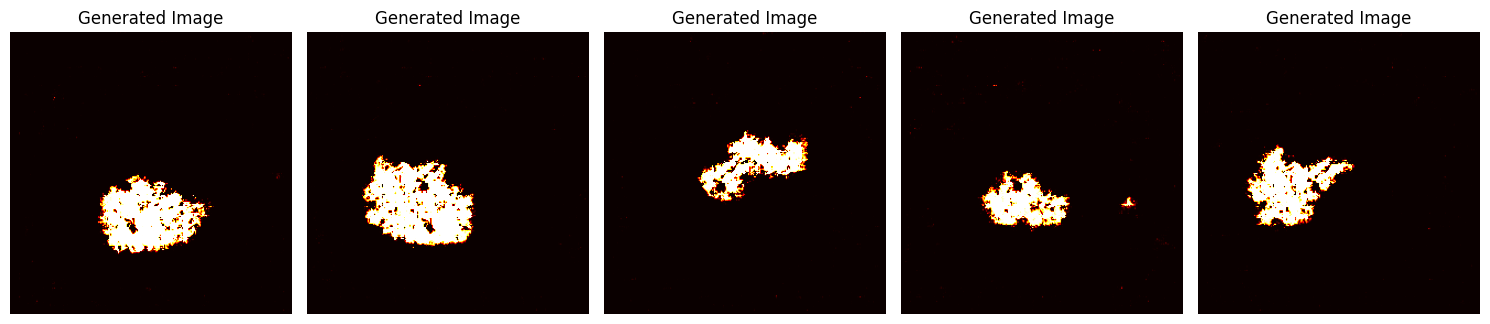

In [58]:
# Assuming 'G' is your generator model, 'device' is your computation device (CPU or GPU), and 'z_dim' is the dimension of the latent space
z_dim = 100  # Replace with the correct dimension of the latent space

# Visualize generated images
visualize_generated_images(G, device, z_dim, num_images_to_generate=5)


This is looking pretty good. In particular, we have lost the dots in the background in the instances where there is no real fire body. The last thing I am going to try is a layer of noise reduction, in order to remove that background speckling even more.

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training:
            noise = x.new_empty(x.size()).normal_(mean=0, std=self.sigma)
            return x + noise
        return x

class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=256):
        super().__init__()
        self.init_size = g_output_dim // 16
        self.fc1 = nn.Linear(g_input_dim, 128 * self.init_size ** 2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            GaussianNoise(sigma=0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(x.shape[0], 128, self.init_size, self.init_size)
        x = self.conv_blocks(x)
        return x


In [ ]:
# build model
G = Generator().to(device)
D = Discriminator().to(device)

# define loss
criterion = nn.BCELoss()
z_dim = 100

# optimiser
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

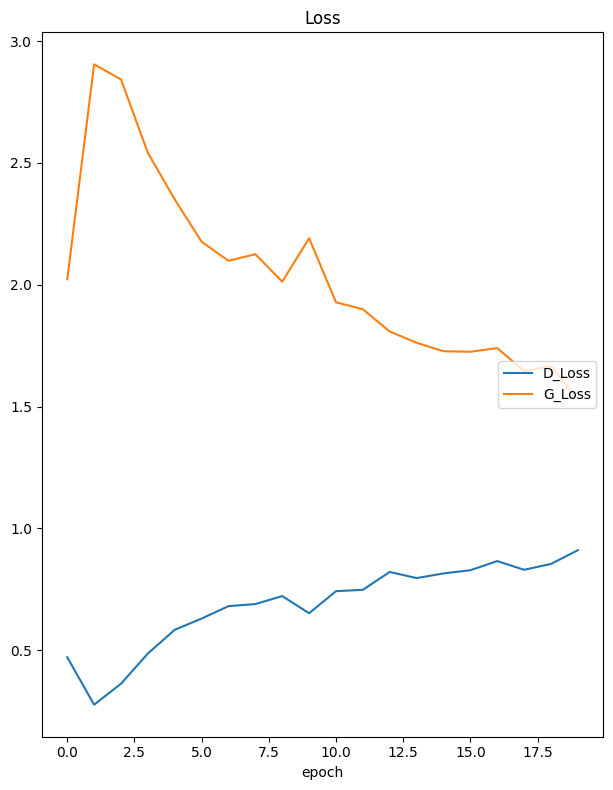

Loss
	D_Loss           	 (min:    0.276, max:    0.910, cur:    0.910)
	G_Loss           	 (min:    1.530, max:    2.905, cur:    1.530)


In [ ]:
n_epoch = 20
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses = [], []
    logs = {}

    for batch_idx, real_images in enumerate(train_loader):
        real_images = real_images.view(-1, 256, 256).to(device)

        D_loss = D_train(real_images)
        # G_loss = G_train(batch_size)
        G_loss = G_train(real_images.size(0))

        D_losses.append(D_loss)
        G_losses.append(G_loss)

    logs['D_Loss'] = torch.tensor(D_losses).mean().item()
    logs['G_Loss'] = torch.tensor(G_losses).mean().item()

    liveloss.update(logs)
    liveloss.draw()

    # save every 20th epochs
    if(np.mod(epoch, 20) == 0):
      torch.save(G.state_dict(), "/content/gdrive/MyDrive/Model/Generator_no_zoom_{:03d}.pth".format(epoch))


In [ ]:
mse = calculate_mse(test_loader, G, device)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.2226334846019745


In [ ]:
def test_data_metrics(model, criterion, data_loader, device):
    total_error = 0
    with torch.no_grad():
        for X_test in data_loader:
            X_test = X_test.float().to(device)
            # X_test_recon, _, _ = model(X_test)
            X_test_recon, _ = model(X_test)
            error = criterion(X_test_recon, X_test)
            total_error += error

    return (total_error / len(data_loader.dataset)).item()

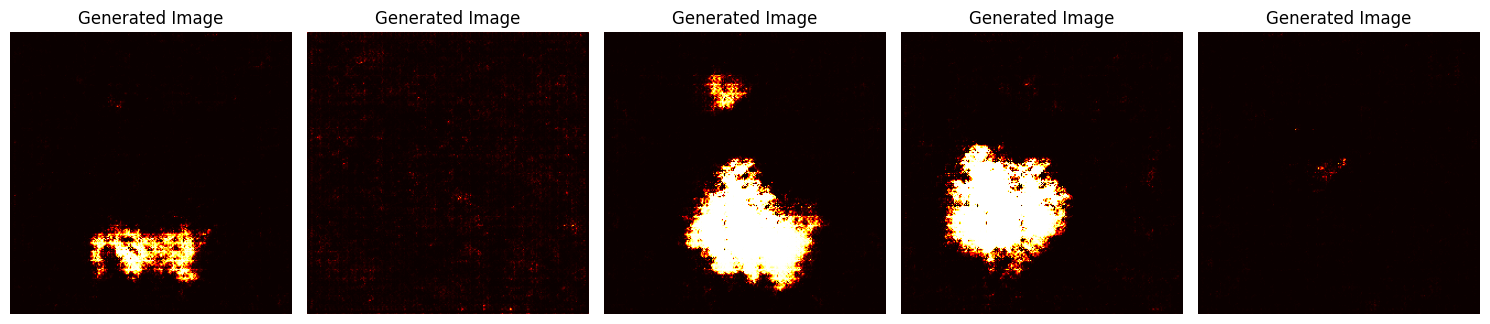

In [ ]:
# Assuming 'G' is your generator model, 'device' is your computation device (CPU or GPU), and 'z_dim' is the dimension of the latent space
z_dim = 100  # Replace with the correct dimension of the latent space

# Visualize generated images
visualize_generated_images(G, device, z_dim, num_images_to_generate=5)


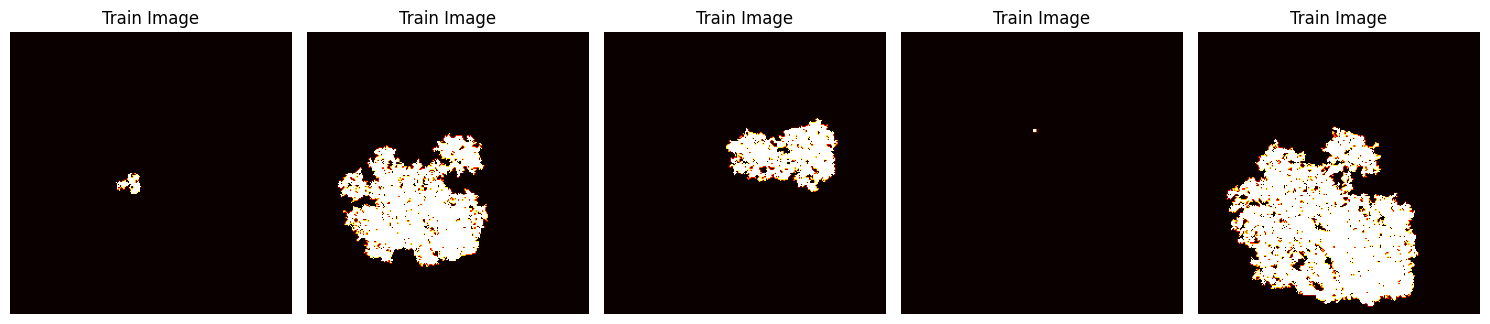

In [ ]:
visualize_random_train_images(train_loader, num_images_to_show=5)

This made my images blurrier and I am starting to get archipelagos. With this in mind, I am going to stick with my model just before.